<a href="https://colab.research.google.com/github/nicolaiberk/Imbalanced/blob/master/ActiveLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro to Active Learning

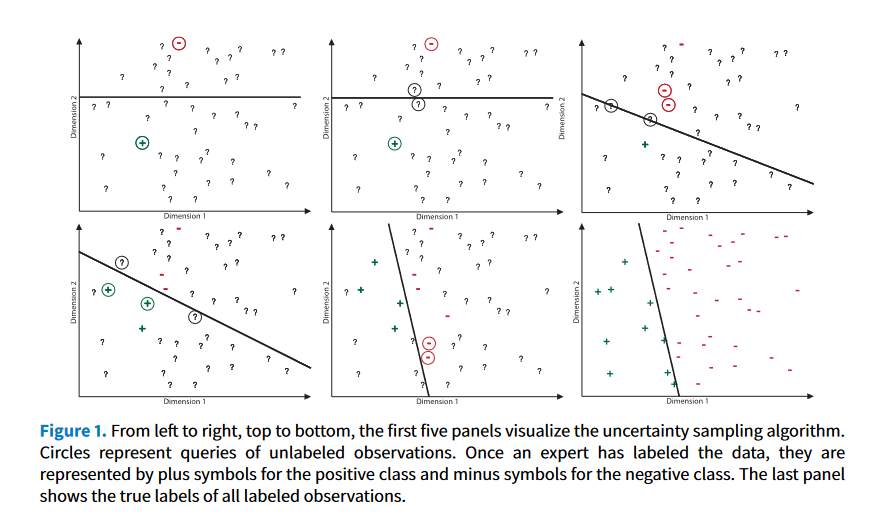

In [2]:
## setup and load data
import pandas as pd

# load relevant packages
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

tweets = pd.read_csv("https://www.dropbox.com/s/gv56nu1ptrp63ps/annotated_german_refugee_tweets.csv?dl=1")

In [ ]:
# general train/test split for assessment of performance

# vectorize entire training set


# Application in Python

## Cold Phase/Initialisation

First, we need a training set to compare our performance against. Second, we need a smaller sample to generate an initial classifier to make uncertainty estimates about our unlabelled data. The size of this starting set will depend on the rareness of the outcome - it has to come up at least once. Let's try to sample 100 cases first:

0.0 positive cases out of a set of 100 in the starting set (0.0%).


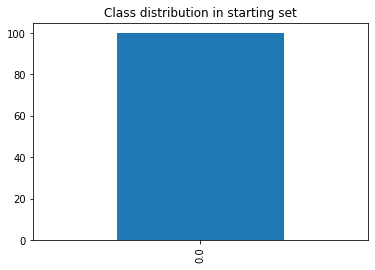

In [7]:
rndsmpl = tweets.sample(n=100,  random_state=42)

X_start = rndsmpl.text
y_start = rndsmpl.annotation

print(f"{sum(y_start)} positive cases out of a set of {len(y_start)} in the starting set ({sum(y_start)*100/len(y_start)}%).")
pd.Series(y_start).value_counts().plot(kind='bar', title='Class distribution in starting set')

Not a single migration-related tweet. Let's increase the sample size:

2.0 positive cases out of a set of 200 in the starting set (1.0%).


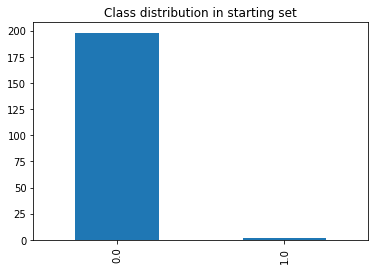

In [8]:
rndsmpl = tweets.sample(n=200,  random_state=42)

X_start = (rndsmpl.text)
y_start = np.array(rndsmpl.annotation)

print(f"{sum(y_start)} positive cases out of a set of {len(y_start)} in the starting set ({sum(y_start)*100/len(y_start)}%).")
pd.Series(y_start).value_counts().plot(kind='bar', title='Class distribution in starting set')

We have **two** positive cases in our sample. That isn't very much, but it should be sufficient to generate estimates for our subsequent sampling procedure.

## Active Phase

In [10]:
# first install modAL package
!pip install modAL

In [11]:
# import modAL
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling

# initializing the learner
learner = ActiveLearner(
    estimator=LogReg(),
    X_training=X_start, y_training=y_start
)

# query for labels
query_idx, query_inst = learner.query(X_pool)

# ...obtaining new labels from the Oracle...

# supply label for queried instance
learner.teach(X_pool[query_idx], y_new)



ValueError: ignored